<a href="https://colab.research.google.com/github/GitHub-Bong/Toxic-Comment-Challenge/blob/master/0409_add_translated_toxic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount, Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
import sys, os, re, string, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, SpatialDropout1D, concatenate, add
from tensorflow.keras.layers import Conv1D, GRU, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

# Load Data

In [ ]:
train = pd.read_csv('/content/drive/Shareddrives/SOGANG Parrot/train.csv/train.csv')
test = pd.read_csv('/content/drive/Shareddrives/SOGANG Parrot/test.csv/test.csv')

In [ ]:
train_fr = pd.read_csv('/content/drive/Shareddrives/SOGANG Parrot/Ho-colab/train_fr.csv')
train_de = pd.read_csv('/content/drive/Shareddrives/SOGANG Parrot/Ho-colab/train_de.csv')
train_es = pd.read_csv('/content/drive/Shareddrives/SOGANG Parrot/Ho-colab/train_es.csv')

In [ ]:
train_fr_toxic = train_fr[train_fr.iloc[:, 2:8].sum(1) != 0]
train_de_toxic = train_de[train_de.iloc[:, 2:8].sum(1) != 0]
train_es_toxic = train_es[train_es.iloc[:, 2:8].sum(1) != 0]

In [ ]:
train_fr_toxic.head(2)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU MISS IN MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,Hey ... what is it ..\n@ | speak .\nWhat is it...,1,0,0,0,0,0


In [ ]:
train_augumented = pd.concat([train, train_fr_toxic, train_de_toxic, train_es_toxic],ignore_index=True)

In [ ]:
train_augumented.shape

(208246, 8)

# Preprocessing

In [ ]:
test['preprocessed'] = test['comment_text']

In [ ]:
train_augumented['preprocessed'] = train_augumented['comment_text']

## Train data

In [ ]:
# 1. Capitalization / Lower case'
train_augumented['preprocessed'] = train_augumented['preprocessed'].apply(lambda x: x.lower())
test['preprocessed'] = test['preprocessed'].apply(lambda x: x.lower())
# 2. Remove ~.jpg , (UTC)
train_augumented['preprocessed'] = train_augumented['preprocessed'].apply(lambda x: re.sub(r"\S+\.jpg|\(UTC\)", " ", x))
test['preprocessed'] = test['preprocessed'].apply(lambda x: re.sub(r"\S+\.jpg|\(UTC\)", " ", x))
# 3. Expand the Contractions
!pip install contractions
import contractions
train_augumented['preprocessed'] = train_augumented['preprocessed'].apply(lambda x: contractions.fix(x))
test['preprocessed'] = test['preprocessed'].apply(lambda x: contractions.fix(x))
# 4. Remove URLs
train_augumented['preprocessed'] = train_augumented['preprocessed'].apply(lambda x: re.sub(r"https?://\S+|www\.\S+", " ", x))
test['preprocessed'] = test['preprocessed'].apply(lambda x: re.sub(r"https?://\S+|www\.\S+", " ", x))
# 5. Remove HTML tags
train_augumented['preprocessed'] = train_augumented['preprocessed'].apply(lambda x: re.sub(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});", " ", x))
test['preprocessed'] = test['preprocessed'].apply(lambda x: re.sub(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});", " ", x))
# 6. Remove Non-ASCI
train_augumented['preprocessed'] = train_augumented['preprocessed'].apply(lambda x: re.sub(r'[^\x00-\x7f]',' ', x))
test['preprocessed'] = test['preprocessed'].apply(lambda x: re.sub(r'[^\x00-\x7f]',' ', x))
# 7. Remove punctuations
train_augumented['preprocessed'] = train_augumented['preprocessed'].apply(lambda x: re.sub(r'[]!"$%&\'()*+,./:;=#@?[\\^_`{|}~-]+', " ", x))
test['preprocessed'] = test['preprocessed'].apply(lambda x: re.sub(r'[]!"$%&\'()*+,./:;=#@?[\\^_`{|}~-]+', " ", x))
# 8. Capitalization / Lower case
train_augumented['preprocessed'] = train_augumented['preprocessed'].apply(lambda x: x.lower())
test['preprocessed'] = test['preprocessed'].apply(lambda x: x.lower())
# # Remove stopwords
# import nltk
# nltk.download('stopwords')
# from nltk.corpus import stopwords
# stop = stopwords.words('english')
# train_fr['2-trans'] = train_fr['2-trans'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

     |████████████████████████████████| 327kB 14.3MB/s 
     |████████████████████████████████| 266kB 21.6MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85394 sha256=f59c41687f357942ab01255d30502f841d4e61b5cd4ab009fa4f0d44f6365abf
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick


In [ ]:
# Find zero len comment
zerolen_t = list()
num = 0
for i in train_augumented['preprocessed']:
  if not re.search('\S',i):
    zerolen_t.append(num)
  num += 1
print(len(zerolen_t))  # 전처리 되어서 ' ' 형태된 갯수 

14


In [ ]:
zerolen_t[:5]

[19815, 41648, 63104, 64904, 68469]

In [ ]:
pd.set_option('max_colwidth', 200)
pd.set_option("max_rows", None)
train_augumented.iloc[zerolen_t,1:]

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,preprocessed
19815,(www.ebenefits.va.gov),0,0,0,0,0,0,
41648,[ ]\nhttp://www.smallholder.co.uk/news/878983.honey_storage/,0,0,0,0,0,0,\n
63104,http://www.everytopicintheuniverseexceptchickens.com/ !!!!,0,0,0,0,0,0,
64904,http://en.wikipedia.org/wiki/Wikipedia_talk:No_original_research/archive15#YouTube_art_as_primary_source,0,0,0,0,0,0,
68469,http://en.wikipedia.org/wiki/Towns_in_the_Former_RSK\nhttp://en.wikipedia.org/wiki/Wikipedia:Articles_for_deletion/Geography_of_the_Former_Republic_of_Serbian_Krajina ( ).,0,0,0,0,0,0,\n
76037,http://finance.yahoo.com/news/7-fascinating-nuggets-another-bewildering-150348488.html,0,0,0,0,0,0,
94038,http://wikipediawehaveaproblem.com/evidence-of-cyberbullying-wp-editors-and-admins/ http://wikipediawehaveaproblem.com/evidence-of-cyberbullying-wp-editors-and-admins/,0,0,0,0,0,0,
106891,http://en.wikipedia.org/wiki/Wikipedia:ELYES,0,0,0,0,0,0,
109944,http://www.newswire.ca/fr/story/358197/domaine-pinnacle-ice-cider-now-available-in-new-european-and-asian-markets .,0,0,0,0,0,0,
123442,http://www.mediamonitors.net/edna47.html http://www.freerepublic.com/forum/a3ad7b207707d.htm,0,0,0,0,0,0,


In [ ]:
train_augumented.iloc[zerolen_t,8] = 'useless'

In [ ]:
train_augumented.iloc[zerolen_t,[1,8]].head(10)

,comment_text,preprocessed
19815,(www.ebenefits.va.gov),useless
41648,[ ]\nhttp://www.smallholder.co.uk/news/878983.honey_storage/,useless
63104,http://www.everytopicintheuniverseexceptchickens.com/ !!!!,useless
64904,http://en.wikipedia.org/wiki/Wikipedia_talk:No_original_research/archive15#YouTube_art_as_primary_source,useless
68469,http://en.wikipedia.org/wiki/Towns_in_the_Former_RSK\nhttp://en.wikipedia.org/wiki/Wikipedia:Articles_for_deletion/Geography_of_the_Former_Republic_of_Serbian_Krajina ( ).,useless
76037,http://finance.yahoo.com/news/7-fascinating-nuggets-another-bewildering-150348488.html,useless
94038,http://wikipediawehaveaproblem.com/evidence-of-cyberbullying-wp-editors-and-admins/ http://wikipediawehaveaproblem.com/evidence-of-cyberbullying-wp-editors-and-admins/,useless
106891,http://en.wikipedia.org/wiki/Wikipedia:ELYES,useless
109944,http://www.newswire.ca/fr/story/358197/domaine-pinnacle-ice-cider-now-available-in-new-european-and-asian-markets .,useless
123442,http://www.mediamonitors.net/edna47.html http://www.freerepublic.com/forum/a3ad7b207707d.htm,useless


In [ ]:
from sklearn.utils import shuffle
train_augumented = shuffle(train_augumented)

In [ ]:
train_augumented.to_csv("/content/drive/Shareddrives/SOGANG Parrot/Ho-colab/0409-contain-stopwords-augu-train.csv", index=False)

In [ ]:
train_augumented = pd.read_csv('/content/drive/Shareddrives/SOGANG Parrot/Ho-colab/0409-contain-stopwords-augu-train.csv')
train_augumented.head(2)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,preprocessed
0,382ac7d058d6154b,Jéské Couriano is a stupid fagot !!!!\n\nJéské...,1,0,1,0,1,1,j sk couriano is a stupid fagot \n\nj sk co...
1,ae47876f18a0e988,"""::::::No, but Wikipedia does have rules of ev...",0,0,0,0,0,0,no but wikipedia does have rules of evidence...


----------

## Test data

In [ ]:
# Find zero len comment
zerolen_te = list()
num = 0
for i in test['preprocessed']:
  if not re.search('\S',i):
    zerolen_te.append(num)
  num += 1
print(len(zerolen_te))  # 전처리 되어서 ''된 갯수 

827


In [ ]:
test.iloc[zerolen_te,[1,2]]

,comment_text,preprocessed
34,일이삼사오육칠팔구하고십이요 에헤헤 으헤 으헤 으허허,
114,পরিচয় \n\n নাম-মোঃফরহাদ ইসলাম \n পিতা-মোঃ শাহজাহান মিয়া \n মাতা-মোছাঃফাহিমা বেগম \n গ্রামঃ জানকিপুর সলই মন্ডল পাড়া \n ইউনিয়নঃনিলাখিয়া \n উপজেলাঃবকশীগঞ্জ \n জেলাঃজামালপুর \n বিভাগঃঢাকা \n\n...,\n\n \n \n \n \n \n \n \n \n\n...
119,السلام عليكم و رحمة الله و بركاته الا الجميع \n تفضلوا جميعا,\n
419,Радченко ис мы дирты гаы анал сех славе!!,
506,== ޗޮޮލ! == \n\n މަލދިވެސ ިސ ަ ޕރެތތޔ ގޮޮދ ިސލަނދ ނަތިޮނ. ި ސުރެ އޮުލދ ލޮވެ ތޮ ގޮ ތހެރެ އިތހ މޔ ފރިެނދސ!,\n\n
578,حاول قراءة صفحات المساعدة والتعليمات \n *,\n
582,"Чини ми се да малим википедијама не преостаје ништа друго него да преводи чланке са вечих. Иначе за СХ википедиу предлажем заједнички нови стандард: јекавица, избациванје ије и ћ, кориштинје славе...",...
674,تعتبر ابنوب من اجمل مدن مصر حيث اصبحت الان قطعة من اوروبا حيث المبانى الشامخة ووجود المصالح الحكومية والنوادى وغيرها وذلك بجهود السيد المحافظ نبيل العزبى واذا نظرنا الى ابنوب وجدنا انها مقسمة الى...,...
819,""" \n ::::::אוקיי אז שיניתי את זה לליד בית חנינא,פשוט באופן כללי כרושמים על איזשהו מקום שנמצא במה שקוראים לו היום """"מזרח ירושלים"""" שהוא לא בתוך ירושלים זה כבר כן קשור לפוליטיקה לדעתי,בכל מקרה תודה ...",\n ...
1278,لڑکی اور لڑکے میں جومحبت پیدا ہوتی ہے، ہوسکتاہے اس کی ابتدا ہی غیر شرعی ہو مثلاً ایک دوسرے سے میل جول ، اور خلوت ، کلام اور بات چيت کرنا اور ایک دوسری کی تصاویر کا تبادلہ وغیرہ۔ یہ سب کام حرام اور...,...


In [ ]:
!pip install google_trans_new
from google_trans_new import google_translator

translator = google_translator()

In [ ]:
zerolen_te.remove(55142)

In [ ]:
test.iloc[zerolen_te,2] = test.iloc[zerolen_te,1].apply(lambda x: translator.translate(x))

In [ ]:
test.iloc[zerolen_te,[1,2]].head(5)

,comment_text,preprocessed
34,일이삼사오육칠팔구하고십이요 에헤헤 으헤 으헤 으허허,"I have a lot of people in the house,"
114,পরিচয় \n\n নাম-মোঃফরহাদ ইসলাম \n পিতা-মোঃ শাহজাহান মিয়া \n মাতা-মোছাঃফাহিমা বেগম \n গ্রামঃ জানকিপুর সলই মন্ডল পাড়া \n ইউনিয়নঃনিলাখিয়া \n উপজেলাঃবকশীগঞ্জ \n জেলাঃজামালপুর \n বিভাগঃঢাকা \n\n...,Identity\n\n Name-Mohammafhorhad Islam\n Father-Mohammad Shahjahan Mia\n Mother-obligeologist Begum\n Village: Janakipur Soli Mandal laid\n UnionNield\n Upazila scholarship\n District --jamalpur\n...
119,السلام عليكم و رحمة الله و بركاته الا الجميع \n تفضلوا جميعا,"Peace, mercy and blessings of God be upon you They all prefer"
419,Радченко ис мы дирты гаы анал сех славе!!,Radchenko IS We are DirTa Gai Anal Sech Glory !!
506,== ޗޮޮލ! == \n\n މަލދިވެސ ިސ ަ ޕރެތތޔ ގޮޮދ ިސލަނދ ނަތިޮނ. ި ސުރެ އޮުލދ ލޮވެ ތޮ ގޮ ތހެރެ އިތހ މޔ ފރިެނދސ!,== ޗޮޮލ! == މަލދިވެސ ިސ ަ ޕރެތތޔ ގޮޮދ ިސލަނދ. ި ސުރެ އޮުލދ ލޮވެ ތޮ ގޮ ތހެރެ އިތހ މޔ ފރިެނދސ!


In [ ]:
# 1. Capitalization / Lower case'
test['preprocessed'] = test['preprocessed'].apply(lambda x: x.lower())
# 2. Remove ~.jpg , (UTC)
test['preprocessed'] = test['preprocessed'].apply(lambda x: re.sub(r"\S+\.jpg|\(UTC\)", " ", x))
# 3. Expand the Contractions
test['preprocessed'] = test['preprocessed'].apply(lambda x: contractions.fix(x))
# 4. Remove URLs
test['preprocessed'] = test['preprocessed'].apply(lambda x: re.sub(r"https?://\S+|www\.\S+", " ", x))
# 5. Remove HTML tags
test['preprocessed'] = test['preprocessed'].apply(lambda x: re.sub(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});", " ", x))
# 6. Remove Non-ASCI
test['preprocessed'] = test['preprocessed'].apply(lambda x: re.sub(r'[^\x00-\x7f]',' ', x))
# 7. Remove punctuations
test['preprocessed'] = test['preprocessed'].apply(lambda x: re.sub(r'[]!"$%&\'()*+,./:;=#@?[\\^_`{|}~-]+', " ", x))
# 8. Capitalization / Lower case
test['preprocessed'] = test['preprocessed'].apply(lambda x: x.lower())

In [ ]:
# Find zero len comment
zerolen_te_2 = list()
num = 0
for i in test['preprocessed']:
  if not re.search('\S',i):
    zerolen_te_2.append(num)
  num += 1
print(len(zerolen_te_2))  # 전처리 되어서 ''된 갯수 

0


In [ ]:
test.iloc[zerolen_te_2,[1,2]]

,comment_text,preprocessed
506,== ޗޮޮލ! == \n\n މަލދިވެސ ިސ ަ ޕރެތތޔ ގޮޮދ ިސލަނދ ނަތިޮނ. ި ސުރެ އޮުލދ ލޮވެ ތޮ ގޮ ތހެރެ އިތހ މޔ ފރިެނދސ!,
4321,== یارمەتی == \n سڵاو خۆشەویست. دەتوانی لێرەدا یارمەتیمان بدەی و ھەروەھا بیروڕای خۆشت بنووسی. زۆر سپاس.,
4856,""" \n\n \n * """,
6533,',
8655,=== ===,
10988,རང་གི་རིག་གནས་ཆུ་ཚད་ཡག་པོ་མེད་ཀྱང་། དྲ་རྒྱའི་རིག་གནས་འདི་ང་ཚོར་དགོས་གལ་ཆེ་བས། ང་ཝེ་ཁེ་བ་ཞིག་བྱེད་པར་སྤྲོ་བོ་ཡོད། ཡིན་ཡང་། གཅིག་ནས་ལག་གསར་ཡིན་པ་དང་། གཉིས་ནས་ཁྱེད་རང་གིས་བྱིན་པའི་ཡིག་ཆ་ཚང་མ་དབྱིན་ཇི...,...
15232,ᡥᡝᠰᡝᡳ ᡨᠣᡴᡨᠣᠪᡠᡥᠠ ᠮᠠᠨᠵᡠᠰᠠᡳ ᠸᡝᠴᡝᡵᡝ ᠮᡝᡨᡝᡵᡝ ᡴᠣᠣᠯᡳ ᠪᡳᡨᡥᡝ,
15672,""" \n\n '''' / """,
16060,* \n * \n * \n * \n * \n * \n * \n * \n * \n * \n * \n * \n * \n * \n * \n * \n * \n * \n *,
16439,ＷＨＡＴＡ ＦＵＣＫ ＭＡＮ ｘＤ ｉ ｊｕｓｔ ｆａｌｌ ｏｆ ｍｙ ｃｈａｉｒ ｋｕｚ ｉ ｃｏｕｌｄｎｔ ａｎｄ ｉ ＣＡＮＴ ｓｔｏｐ ｌａｕｇｈ ｘＤＸＤＸＤＸＤＸＤＤＤＤＤＤＤＤＤＤＤＤＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＤＤＤＤＤＤＤＤＤＤＤＤＤＤＤＤＤＤＤ ＯＭＧＯＳＨ \n ＤＤＤＤＤＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸ...,\n ...


In [ ]:
test.iloc[[16439,71320,],2] = 'toxic'

In [ ]:
zerolen_te_2.remove(16439)

In [ ]:
zerolen_te_2.remove(71320)

In [ ]:
test.iloc[zerolen_te_2,2] = 'unknown'

In [ ]:
test['preprocessed'].isnull().values.any()

False

In [ ]:
test.to_csv("/content/drive/Shareddrives/SOGANG Parrot/Ho-colab/0409-contain-stopwords-augu-test.csv", index=False)

In [ ]:
test = pd.read_csv("/content/drive/Shareddrives/SOGANG Parrot/Ho-colab/0409-contain-stopwords-augu-test.csv")
test.shape

(153164, 3)

# New Train, Test data

In [ ]:
train_augumented = pd.read_csv('/content/drive/Shareddrives/SOGANG Parrot/Ho-colab/0409-contain-stopwords-augu-train.csv')
train_augumented.shape

(208246, 9)

In [ ]:
test = pd.read_csv("/content/drive/Shareddrives/SOGANG Parrot/Ho-colab/0409-contain-stopwords-augu-test.csv")
test.shape

(153164, 3)

# Tokenization

In [ ]:
list_sentences_train = train_augumented['preprocessed'] # (208246,)
list_sentences_test = test['comment_text'] # (153164,)

In [ ]:
texts = pd.concat([list_sentences_train , list_sentences_test],axis=0,ignore_index=True).astype("str")

In [ ]:
max_features = 100000
tokenizer = Tokenizer(num_words=max_features, lower=False)
tokenizer.fit_on_texts(texts)
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
# list_tokenized_train[:1] = [[688,75,1,126,130, ,,, ]]
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
# list_tokenized_test[:1] = [[2665,655,8849,656, ,,, ]]

# tokenizer.word_counts = OrderedDict([('explanation', 1771),('why', 17818),('the', 496540),('edits', 9957), ,,, ])
# tokenizer.word_index = {'the': 1,'to': 2,'of': 3,'and': 4, ,,, }
len(tokenizer.word_index)

442562

# Padding

In [ ]:
train_augumented['length'] = train_augumented['preprocessed'].apply(lambda x: len(x.split()))
test['length'] = test['comment_text'].apply(lambda x: len(x.split()))

In [ ]:
train_augumented['length'].quantile([.8])

0.8    86.0
Name: length, dtype: float64

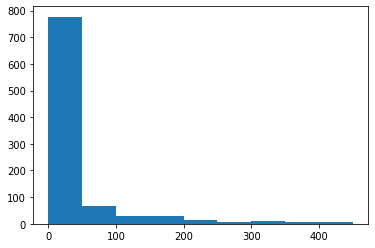

In [ ]:
plt.hist(train_augumented['length'].value_counts(),bins = np.arange(0,500,50))
plt.show()

In [ ]:
test['length'].quantile([.8])

0.8    81.0
Name: length, dtype: float64

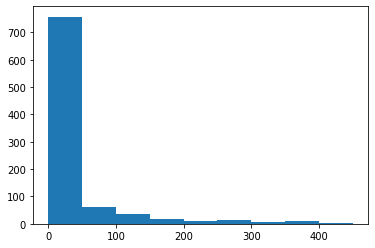

In [ ]:
plt.hist(test['length'].value_counts(),bins = np.arange(0,500,50))
plt.show()

In [ ]:
maxlen = 100
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen) # (208246, 100)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen) # (153164, 100)

X_t.shape

(208246, 100)

In [ ]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train_augumented[list_classes].values # y.shape (208246, 6)
y.shape

(208246, 6)

# Pretrained-Embedding-matrix

In [ ]:
embedding_dict = dict()
f = open('/content/drive/Shareddrives/SOGANG Parrot/Pretrained-Embedding-Vector/glove.twitter.27B.200d.txt/glove.twitter.27B.200d.txt', encoding="utf8")

for line in f:
    word_vector = line.split()
    word = word_vector[0]
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32') # 200
    embedding_dict[word] = word_vector_arr
f.close()
print('There are %s Embedding Vectors\n' % len(embedding_dict))

print(embedding_dict['respectable'])
print(len(embedding_dict['respectable']))

embedding_matrix = np.zeros((len(tokenizer.word_index)+1, 200)) # will delete first row

for word, i in tokenizer.word_index.items(): 
    temp = embedding_dict.get(word) 
    if temp is not None:
        embedding_matrix[i] = temp 

print(embedding_matrix.shape)
embedding_matrix = np.delete(embedding_matrix,0,axis=0) # delete first row
print(embedding_matrix.shape)

There are 1193514 Embedding Vectors

[-6.4748e-01 -3.7296e-01 -3.6128e-01  7.9975e-01 -2.1890e-01  7.6152e-01
 -7.3698e-02  2.2635e-01 -7.5429e-02  6.3600e-01 -6.5914e-01 -5.1787e-01
 -6.4411e-02 -3.0796e-01  4.4071e-01  1.4543e-01 -9.9792e-02 -2.3253e-01
  2.0882e-01 -9.3256e-02 -2.9659e-01 -1.6643e-01 -1.3184e-01 -5.5247e-01
 -6.0625e-01  9.6745e-01  3.8410e-01 -1.4236e-02  2.8774e-01  7.5652e-01
  1.1552e-01 -4.9894e-01 -9.2585e-02 -6.7708e-02  3.1373e-01  5.6426e-01
  1.9797e-01  4.0703e-02  2.7106e-01 -3.3045e-01  3.9652e-01  1.3718e-01
  5.0194e-01  3.7811e-01  2.9139e-01  2.6001e-01  2.9927e-01  3.6737e-01
  1.0638e-01  3.7086e-01  2.3767e-02  6.4266e-01 -2.4067e-01 -3.1749e-01
 -3.4070e-01  9.3053e-01  1.8900e-01 -2.7260e-01 -3.5132e-01  1.4086e-01
 -1.6232e-01  8.7983e-03 -8.7401e-02 -1.2887e-01  2.5303e-01  9.0737e-01
 -3.3149e-01  5.8059e-02 -2.3855e-01  3.5351e-01 -3.8560e-01 -4.6745e-01
 -2.2487e-01 -1.9058e-01  3.4685e-02  4.1231e-01  9.3602e-02  2.0409e-01
 -2.4806e-01  

In [ ]:
np.save('/content/drive/Shareddrives/SOGANG Parrot/Pretrained-Embedding-Vector/0410-contain-stopwords-200d-pretrained-embed-Glove.npy',embedding_matrix)

In [ ]:
embedding_matrix = np.load('/content/drive/Shareddrives/SOGANG Parrot/Pretrained-Embedding-Vector/0410-contain-stopwords-200d-pretrained-embed-Glove.npy')
embedding_matrix.shape

(442562, 200)

# Model

In [ ]:
inp = Input(shape=(maxlen, )) #maxlen=100
x = Embedding(len(tokenizer.word_index), embedding_matrix.shape[1],
              weights=[embedding_matrix],trainable=False)(inp)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(128, return_sequences=True))(x)
x = Conv1D(64, 3, padding='valid', kernel_initializer='glorot_uniform')(x)
max_pool = GlobalMaxPooling1D()(x)
avg_pool = GlobalAveragePooling1D()(x)
conc = concatenate([avg_pool, max_pool])
x = Dense(128, activation="relu")(conc)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)

In [ ]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 200)     88512400    input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 100, 200)     0           embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 100, 256)     253440      spatial_dropout1d[0][0]          
______________________________________________________________________________________________

In [ ]:
tf.keras.backend.clear_session()

from tensorflow.keras.callbacks import ModelCheckpoint
#checkpoint
checkpoint = ModelCheckpoint(filepath='/content/drive/Shareddrives/SOGANG Parrot/Trained-Model/0410-contain-stopwords-pretrained-embed-Glove.hdf5', monitor='val_loss', verbose=1, save_best_only=True)

batch_size = 128
epochs = 25
hist = model.fit(X_t,y, batch_size=batch_size, epochs=epochs, callbacks=[checkpoint], validation_split=0.1)

Epoch 1/25
1465/1465 [==============================] - 126s 63ms/step - loss: 0.2174 - accuracy: 0.9177 - val_loss: 0.1401 - val_accuracy: 0.9824

Epoch 00001: val_loss improved from inf to 0.14012, saving model to /content/drive/Shareddrives/SOGANG Parrot/Trained-Model/0410-contain-stopwords-pretrained-embed-Glove.hdf5
Epoch 2/25
1465/1465 [==============================] - 91s 62ms/step - loss: 0.1398 - accuracy: 0.9737 - val_loss: 0.1265 - val_accuracy: 0.9814

Epoch 00002: val_loss improved from 0.14012 to 0.12654, saving model to /content/drive/Shareddrives/SOGANG Parrot/Trained-Model/0410-contain-stopwords-pretrained-embed-Glove.hdf5
Epoch 3/25
1465/1465 [==============================] - 91s 62ms/step - loss: 0.1265 - accuracy: 0.9691 - val_loss: 0.1200 - val_accuracy: 0.9605

Epoch 00003: val_loss improved from 0.12654 to 0.12004, saving model to /content/drive/Shareddrives/SOGANG Parrot/Trained-Model/0410-contain-stopwords-pretrained-embed-Glove.hdf5
Epoch 4/25
1465/1465 [===

KeyboardInterrupt: ignored

In [ ]:
sample_submission = pd.read_csv("/content/drive/Shareddrives/SOGANG Parrot/sample_submission.csv/sample_submission.csv")

sample_submission[list_classes] = model.predict(X_te)

sample_submission.to_csv("/content/drive/Shareddrives/SOGANG Parrot/All-submission/0409-contain-stopwords-pretrained-embed-Glove.csv", index=False)

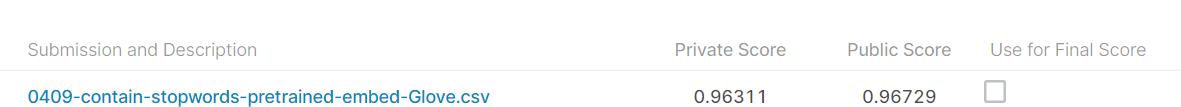

----------

# Change

In [ ]:
list_sentences_train = train_augumented['preprocessed'] # (208246,)
list_sentences_test = test['preprocessed'] # (153164,)

max_features = 50000
tokenizer = Tokenizer(num_words=max_features, lower=False)
tokenizer.fit_on_texts(list_sentences_train)
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
# list_tokenized_train[:1] = [[688,75,1,126,130, ,,, ]]
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
# list_tokenized_test[:1] = [[2665,655,8849,656, ,,, ]]

# tokenizer.word_counts = OrderedDict([('explanation', 1771),('why', 17818),('the', 496540),('edits', 9957), ,,, ])
# tokenizer.word_index = {'the': 1,'to': 2,'of': 3,'and': 4, ,,, }
len(tokenizer.word_index)

177632

In [ ]:
maxlen = 100
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen) # (208246, 100)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen) # (153164, 100)

list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train_augumented[list_classes].values # y.shape (208246, 6)

y.shape, X_t.shape

((208246, 6), (208246, 100))

In [ ]:
np.save('/content/drive/Shareddrives/SOGANG Parrot/Pretrained-Embedding-Vector/0409-v2-contain-stopwords-200d-pretrained-embed-Glove.npy',embedding_matrix)

In [ ]:
embedding_matrix = np.load('/content/drive/Shareddrives/SOGANG Parrot/Pretrained-Embedding-Vector/0409-v2-contain-stopwords-200d-pretrained-embed-Glove.npy')
embedding_matrix.shape

(177632, 200)

In [ ]:
inp = Input(shape=(maxlen, )) #maxlen=100
x = Embedding(len(tokenizer.word_index), embedding_matrix.shape[1],
              weights=[embedding_matrix],trainable=False)(inp)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(64, return_sequences=True))(x)
max_pool = GlobalMaxPooling1D()(x)
avg_pool = GlobalAveragePooling1D()(x)
conc = concatenate([avg_pool, max_pool])
x = Dropout(0.2)(conc)
x = Dense(64, 'relu')(x)
x = Dropout(0.2)(x)
x = Dense(6, activation="sigmoid")(x)

In [ ]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 200)     35526400    input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 100, 200)     0           embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 100, 128)     102144      spatial_dropout1d[0][0]          
______________________________________________________________________________________________

In [ ]:
tf.keras.backend.clear_session()

from tensorflow.keras.callbacks import ModelCheckpoint
#checkpoint
checkpoint = ModelCheckpoint(filepath='/content/drive/Shareddrives/SOGANG Parrot/Trained-Model/0409-v3-contain-stopwords-pretrained-embed-Glove.hdf5', monitor='val_loss', verbose=1, save_best_only=True)

batch_size = 128
epochs = 30
hist = model.fit(X_t,y, batch_size=batch_size, epochs=epochs, callbacks=[checkpoint], validation_split=0.1)

Epoch 1/30
1465/1465 [==============================] - 25s 15ms/step - loss: 0.2427 - accuracy: 0.9064 - val_loss: 0.1457 - val_accuracy: 0.9825

Epoch 00001: val_loss improved from inf to 0.14565, saving model to /content/drive/Shareddrives/SOGANG Parrot/Trained-Model/0409-v3-contain-stopwords-pretrained-embed-Glove.hdf5
Epoch 2/30
1465/1465 [==============================] - 23s 15ms/step - loss: 0.1552 - accuracy: 0.9804 - val_loss: 0.1319 - val_accuracy: 0.9825

Epoch 00002: val_loss improved from 0.14565 to 0.13188, saving model to /content/drive/Shareddrives/SOGANG Parrot/Trained-Model/0409-v3-contain-stopwords-pretrained-embed-Glove.hdf5
Epoch 3/30
1465/1465 [==============================] - 23s 16ms/step - loss: 0.1413 - accuracy: 0.9816 - val_loss: 0.1236 - val_accuracy: 0.9825

Epoch 00003: val_loss improved from 0.13188 to 0.12363, saving model to /content/drive/Shareddrives/SOGANG Parrot/Trained-Model/0409-v3-contain-stopwords-pretrained-embed-Glove.hdf5
Epoch 4/30
1465/1

In [ ]:
sample_submission = pd.read_csv("/content/drive/Shareddrives/SOGANG Parrot/sample_submission.csv/sample_submission.csv")

sample_submission[list_classes] = model.predict(X_te)

sample_submission.to_csv("/content/drive/Shareddrives/SOGANG Parrot/All-submission/0409-v3-contain-stopwords-pretrained-embed-Glove.csv", index=False)

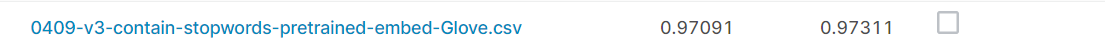

----------------

# Change

In [ ]:
list_sentences_train = train_augumented['preprocessed'] # (208246,)
list_sentences_test = test['preprocessed'] # (153164,)

max_features = 30000
tokenizer = Tokenizer(num_words=max_features, lower=False)
tokenizer.fit_on_texts(list_sentences_train)
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
# list_tokenized_train[:1] = [[688,75,1,126,130, ,,, ]]
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
# list_tokenized_test[:1] = [[2665,655,8849,656, ,,, ]]

# tokenizer.word_counts = OrderedDict([('explanation', 1771),('why', 17818),('the', 496540),('edits', 9957), ,,, ])
# tokenizer.word_index = {'the': 1,'to': 2,'of': 3,'and': 4, ,,, }
len(tokenizer.word_index)

177632

In [ ]:
maxlen = 100
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen) # (208246, 100)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen) # (153164, 100)

list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train_augumented[list_classes].values # y.shape (208246, 6)

y.shape, X_t.shape

((208246, 6), (208246, 100))

In [ ]:
embedding_dict = dict()
f = open('/content/drive/Shareddrives/SOGANG Parrot/Pretrained-Embedding-Vector/glove.twitter.27B.200d.txt/glove.twitter.27B.200d.txt', encoding="utf8")

for line in f:
    word_vector = line.split()
    word = word_vector[0]
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32') # 200
    embedding_dict[word] = word_vector_arr
f.close()
print('There are %s Embedding Vectors\n' % len(embedding_dict))

print(embedding_dict['respectable'])
print(len(embedding_dict['respectable']))

embedding_matrix = np.zeros((len(tokenizer.word_index)+1, 200)) # will delete first row

for word, i in tokenizer.word_index.items(): 
    temp = embedding_dict.get(word) 
    if temp is not None:
        embedding_matrix[i] = temp 

print(embedding_matrix.shape)
embedding_matrix = np.delete(embedding_matrix,0,axis=0) # delete first row
print(embedding_matrix.shape)

There are 1193514 Embedding Vectors

[-6.4748e-01 -3.7296e-01 -3.6128e-01  7.9975e-01 -2.1890e-01  7.6152e-01
 -7.3698e-02  2.2635e-01 -7.5429e-02  6.3600e-01 -6.5914e-01 -5.1787e-01
 -6.4411e-02 -3.0796e-01  4.4071e-01  1.4543e-01 -9.9792e-02 -2.3253e-01
  2.0882e-01 -9.3256e-02 -2.9659e-01 -1.6643e-01 -1.3184e-01 -5.5247e-01
 -6.0625e-01  9.6745e-01  3.8410e-01 -1.4236e-02  2.8774e-01  7.5652e-01
  1.1552e-01 -4.9894e-01 -9.2585e-02 -6.7708e-02  3.1373e-01  5.6426e-01
  1.9797e-01  4.0703e-02  2.7106e-01 -3.3045e-01  3.9652e-01  1.3718e-01
  5.0194e-01  3.7811e-01  2.9139e-01  2.6001e-01  2.9927e-01  3.6737e-01
  1.0638e-01  3.7086e-01  2.3767e-02  6.4266e-01 -2.4067e-01 -3.1749e-01
 -3.4070e-01  9.3053e-01  1.8900e-01 -2.7260e-01 -3.5132e-01  1.4086e-01
 -1.6232e-01  8.7983e-03 -8.7401e-02 -1.2887e-01  2.5303e-01  9.0737e-01
 -3.3149e-01  5.8059e-02 -2.3855e-01  3.5351e-01 -3.8560e-01 -4.6745e-01
 -2.2487e-01 -1.9058e-01  3.4685e-02  4.1231e-01  9.3602e-02  2.0409e-01
 -2.4806e-01  

In [ ]:
np.save('/content/drive/Shareddrives/SOGANG Parrot/Pretrained-Embedding-Vector/0409-v4-contain-stopwords-200d-pretrained-embed-Glove.npy',embedding_matrix)

In [ ]:
embedding_matrix = np.load('/content/drive/Shareddrives/SOGANG Parrot/Pretrained-Embedding-Vector/0409-v4-contain-stopwords-200d-pretrained-embed-Glove.npy')
embedding_matrix.shape

(177632, 200)

In [ ]:
inp = Input(shape=(maxlen, )) #maxlen=100
x = Embedding(len(tokenizer.word_index), embedding_matrix.shape[1],
              weights=[embedding_matrix],trainable=False)(inp)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(64, return_sequences=True))(x)
max_pool = GlobalMaxPooling1D()(x)
avg_pool = GlobalAveragePooling1D()(x)
conc = concatenate([avg_pool, max_pool])
x = Dropout(0.1)(conc)
x = Dense(6, activation="sigmoid")(x)

In [ ]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 200)     35526400    input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 100, 200)     0           embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 100, 128)     102144      spatial_dropout1d[0][0]          
______________________________________________________________________________________________

In [ ]:
tf.keras.backend.clear_session()

from tensorflow.keras.callbacks import ModelCheckpoint
#checkpoint
checkpoint = ModelCheckpoint(filepath='/content/drive/Shareddrives/SOGANG Parrot/Trained-Model/0409-v4-contain-stopwords-pretrained-embed-Glove.hdf5', monitor='val_loss', verbose=1, save_best_only=True)

batch_size = 128
epochs = 25
hist = model.fit(X_t,y, batch_size=batch_size, epochs=epochs, callbacks=[checkpoint], validation_split=0.1)

Epoch 1/25
1465/1465 [==============================] - 26s 16ms/step - loss: 0.2485 - accuracy: 0.9138 - val_loss: 0.1430 - val_accuracy: 0.9750

Epoch 00001: val_loss improved from inf to 0.14297, saving model to /content/drive/Shareddrives/SOGANG Parrot/Trained-Model/0409-v4-contain-stopwords-pretrained-embed-Glove.hdf5
Epoch 2/25
1465/1465 [==============================] - 22s 15ms/step - loss: 0.1468 - accuracy: 0.9565 - val_loss: 0.1292 - val_accuracy: 0.9741

Epoch 00002: val_loss improved from 0.14297 to 0.12921, saving model to /content/drive/Shareddrives/SOGANG Parrot/Trained-Model/0409-v4-contain-stopwords-pretrained-embed-Glove.hdf5
Epoch 3/25
1465/1465 [==============================] - 22s 15ms/step - loss: 0.1345 - accuracy: 0.9546 - val_loss: 0.1239 - val_accuracy: 0.9261

Epoch 00003: val_loss improved from 0.12921 to 0.12386, saving model to /content/drive/Shareddrives/SOGANG Parrot/Trained-Model/0409-v4-contain-stopwords-pretrained-embed-Glove.hdf5
Epoch 4/25
1465/1

In [ ]:
sample_submission = pd.read_csv("/content/drive/Shareddrives/SOGANG Parrot/sample_submission.csv/sample_submission.csv")

sample_submission[list_classes] = model.predict(X_te)

sample_submission.to_csv("/content/drive/Shareddrives/SOGANG Parrot/All-submission/0409-v4-contain-stopwords-pretrained-embed-Glove.csv", index=False)

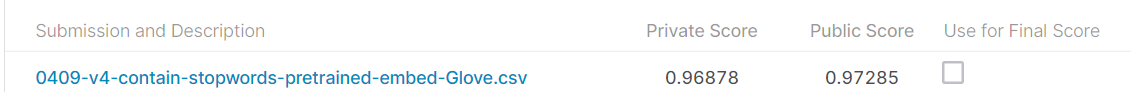

-------------

# Change

In [ ]:
list_sentences_train = train_augumented['preprocessed'] # (208246,)
list_sentences_test = test['preprocessed'] # (153164,)

max_features = 50000
tokenizer = Tokenizer(num_words=max_features, lower=False)
tokenizer.fit_on_texts(list_sentences_train)
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
# list_tokenized_train[:1] = [[688,75,1,126,130, ,,, ]]
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
# list_tokenized_test[:1] = [[2665,655,8849,656, ,,, ]]

# tokenizer.word_counts = OrderedDict([('explanation', 1771),('why', 17818),('the', 496540),('edits', 9957), ,,, ])
# tokenizer.word_index = {'the': 1,'to': 2,'of': 3,'and': 4, ,,, }
len(tokenizer.word_index)

177632

In [ ]:
maxlen = 100
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen) # (208246, 100)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen) # (153164, 100)

list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train_augumented[list_classes].values # y.shape (208246, 6)

y.shape, X_t.shape

((208246, 6), (208246, 100))

In [ ]:
embedding_matrix = np.load('/content/drive/Shareddrives/SOGANG Parrot/Pretrained-Embedding-Vector/0409-v2-contain-stopwords-200d-pretrained-embed-Glove.npy')
embedding_matrix.shape

(177632, 200)

In [ ]:
inp = Input(shape=(maxlen, )) #maxlen=100
x = Embedding(len(tokenizer.word_index), embedding_matrix.shape[1],
              weights=[embedding_matrix],trainable=False)(inp)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(64, return_sequences=True))(x)
max_pool = GlobalMaxPooling1D()(x)
avg_pool = GlobalAveragePooling1D()(x)
conc = concatenate([avg_pool, max_pool])
x = Dropout(0.2)(conc)
x = Dense(64, 'relu')(x)
x = Dropout(0.2)(x)
x = Dense(6, activation="sigmoid")(x)

In [ ]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 200)     35526400    input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 100, 200)     0           embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 100, 128)     102144      spatial_dropout1d[0][0]          
______________________________________________________________________________________________

In [ ]:
tf.keras.backend.clear_session()

from tensorflow.keras.callbacks import ModelCheckpoint
#checkpoint
checkpoint = ModelCheckpoint(filepath='/content/drive/Shareddrives/SOGANG Parrot/Trained-Model/0409-v5-contain-stopwords-pretrained-embed-Glove.hdf5', monitor='val_loss', verbose=1, save_best_only=True)

batch_size = 64
epochs = 30
hist = model.fit(X_t,y, batch_size=batch_size, epochs=epochs, callbacks=[checkpoint], validation_split=0.1)

Epoch 1/30
2929/2929 [==============================] - 41s 13ms/step - loss: 0.2292 - accuracy: 0.8716 - val_loss: 0.1402 - val_accuracy: 0.9825

Epoch 00001: val_loss improved from inf to 0.14024, saving model to /content/drive/Shareddrives/SOGANG Parrot/Trained-Model/0409-v5-contain-stopwords-pretrained-embed-Glove.hdf5
Epoch 2/30
2929/2929 [==============================] - 39s 13ms/step - loss: 0.1495 - accuracy: 0.9788 - val_loss: 0.1275 - val_accuracy: 0.9825

Epoch 00002: val_loss improved from 0.14024 to 0.12745, saving model to /content/drive/Shareddrives/SOGANG Parrot/Trained-Model/0409-v5-contain-stopwords-pretrained-embed-Glove.hdf5
Epoch 3/30
2929/2929 [==============================] - 39s 13ms/step - loss: 0.1361 - accuracy: 0.9802 - val_loss: 0.1227 - val_accuracy: 0.9825

Epoch 00003: val_loss improved from 0.12745 to 0.12272, saving model to /content/drive/Shareddrives/SOGANG Parrot/Trained-Model/0409-v5-contain-stopwords-pretrained-embed-Glove.hdf5
Epoch 4/30
2929/2

In [ ]:
sample_submission = pd.read_csv("/content/drive/Shareddrives/SOGANG Parrot/sample_submission.csv/sample_submission.csv")

sample_submission[list_classes] = model.predict(X_te)

sample_submission.to_csv("/content/drive/Shareddrives/SOGANG Parrot/All-submission/0409-v5-contain-stopwords-pretrained-embed-Glove.csv", index=False)

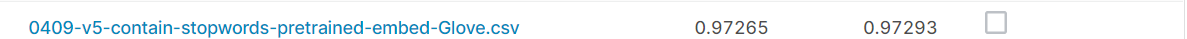

---------------

# Average

In [ ]:
ans1 = pd.read_csv("/content/drive/Shareddrives/SOGANG Parrot/All-submission/0409-v3-contain-stopwords-pretrained-embed-Glove.csv")
ans2 = pd.read_csv("/content/drive/Shareddrives/SOGANG Parrot/All-submission/0409-v4-contain-stopwords-pretrained-embed-Glove.csv")
ans3 = pd.read_csv("/content/drive/Shareddrives/SOGANG Parrot/All-submission/0409-v5-contain-stopwords-pretrained-embed-Glove.csv")

In [ ]:
ans = ans1.iloc[:,1:] + ans2.iloc[:,1:] + ans3.iloc[:,1:]
ans = ans / 3
ans.head(2)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0.998422,0.504603,0.993348,0.063261,0.975688,0.346266
1,0.000549,0.000039,0.000130,0.000016,0.000043,0.000040


In [ ]:
sample_submission = pd.read_csv("/content/drive/Shareddrives/SOGANG Parrot/sample_submission.csv/sample_submission.csv")

sample_submission[list_classes] = ans

sample_submission.to_csv("/content/drive/Shareddrives/SOGANG Parrot/All-submission/0409-avg-contain-stopwords-pretrained-embed-Glove.csv", index=False)

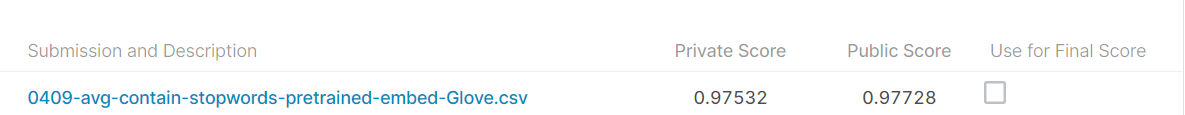